# Fashion Recommender System Using Chatbot

# Final Project Hacktiv8 Batch 013

# Introduction

Group 4 :
- Maulana Azmi Izzuddin
- Azis Muslim
- Xyla Ramadhan

## Objective

- Build a Fashion Recommendation System to give an experience to customers in selecting their outfits.
- Integrate Fashion Recommendation System with chatbot.

## Dataset

Dataset contain high resolution product images of fashion from e-commerce industry.

Source : https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

# Import Library

In [48]:
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import image
from keras.layers import GlobalMaxPooling2D
from keras.applications import ResNet50
from keras.applications.resnet import ResNet50,preprocess_input
import numpy as np
from numpy.linalg import norm
import os
import urllib.request
from PIL import Image
from tqdm import tqdm
import pickle
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Loading Data

Loading CSV file yang berisikan file name, directory dari foto, dan url link untuk foto products:

In [3]:
# Loading CSV file
df = pd.read_csv('df_image.csv')
df.head()

filename                                               link  directory
0  1163.jpg  http://assets.myntassets.com/v1/images/style/p...       1163
1  1164.jpg  http://assets.myntassets.com/v1/images/style/p...       1164
2  1165.jpg  http://assets.myntassets.com/assets/images/116...       1165
3  1525.jpg  http://assets.myntassets.com/v1/images/style/p...       1525
4  1526.jpg  http://assets.myntassets.com/v1/images/style/p...       1526

# EDA

Melihat  beberapa product yang ada di dataset :

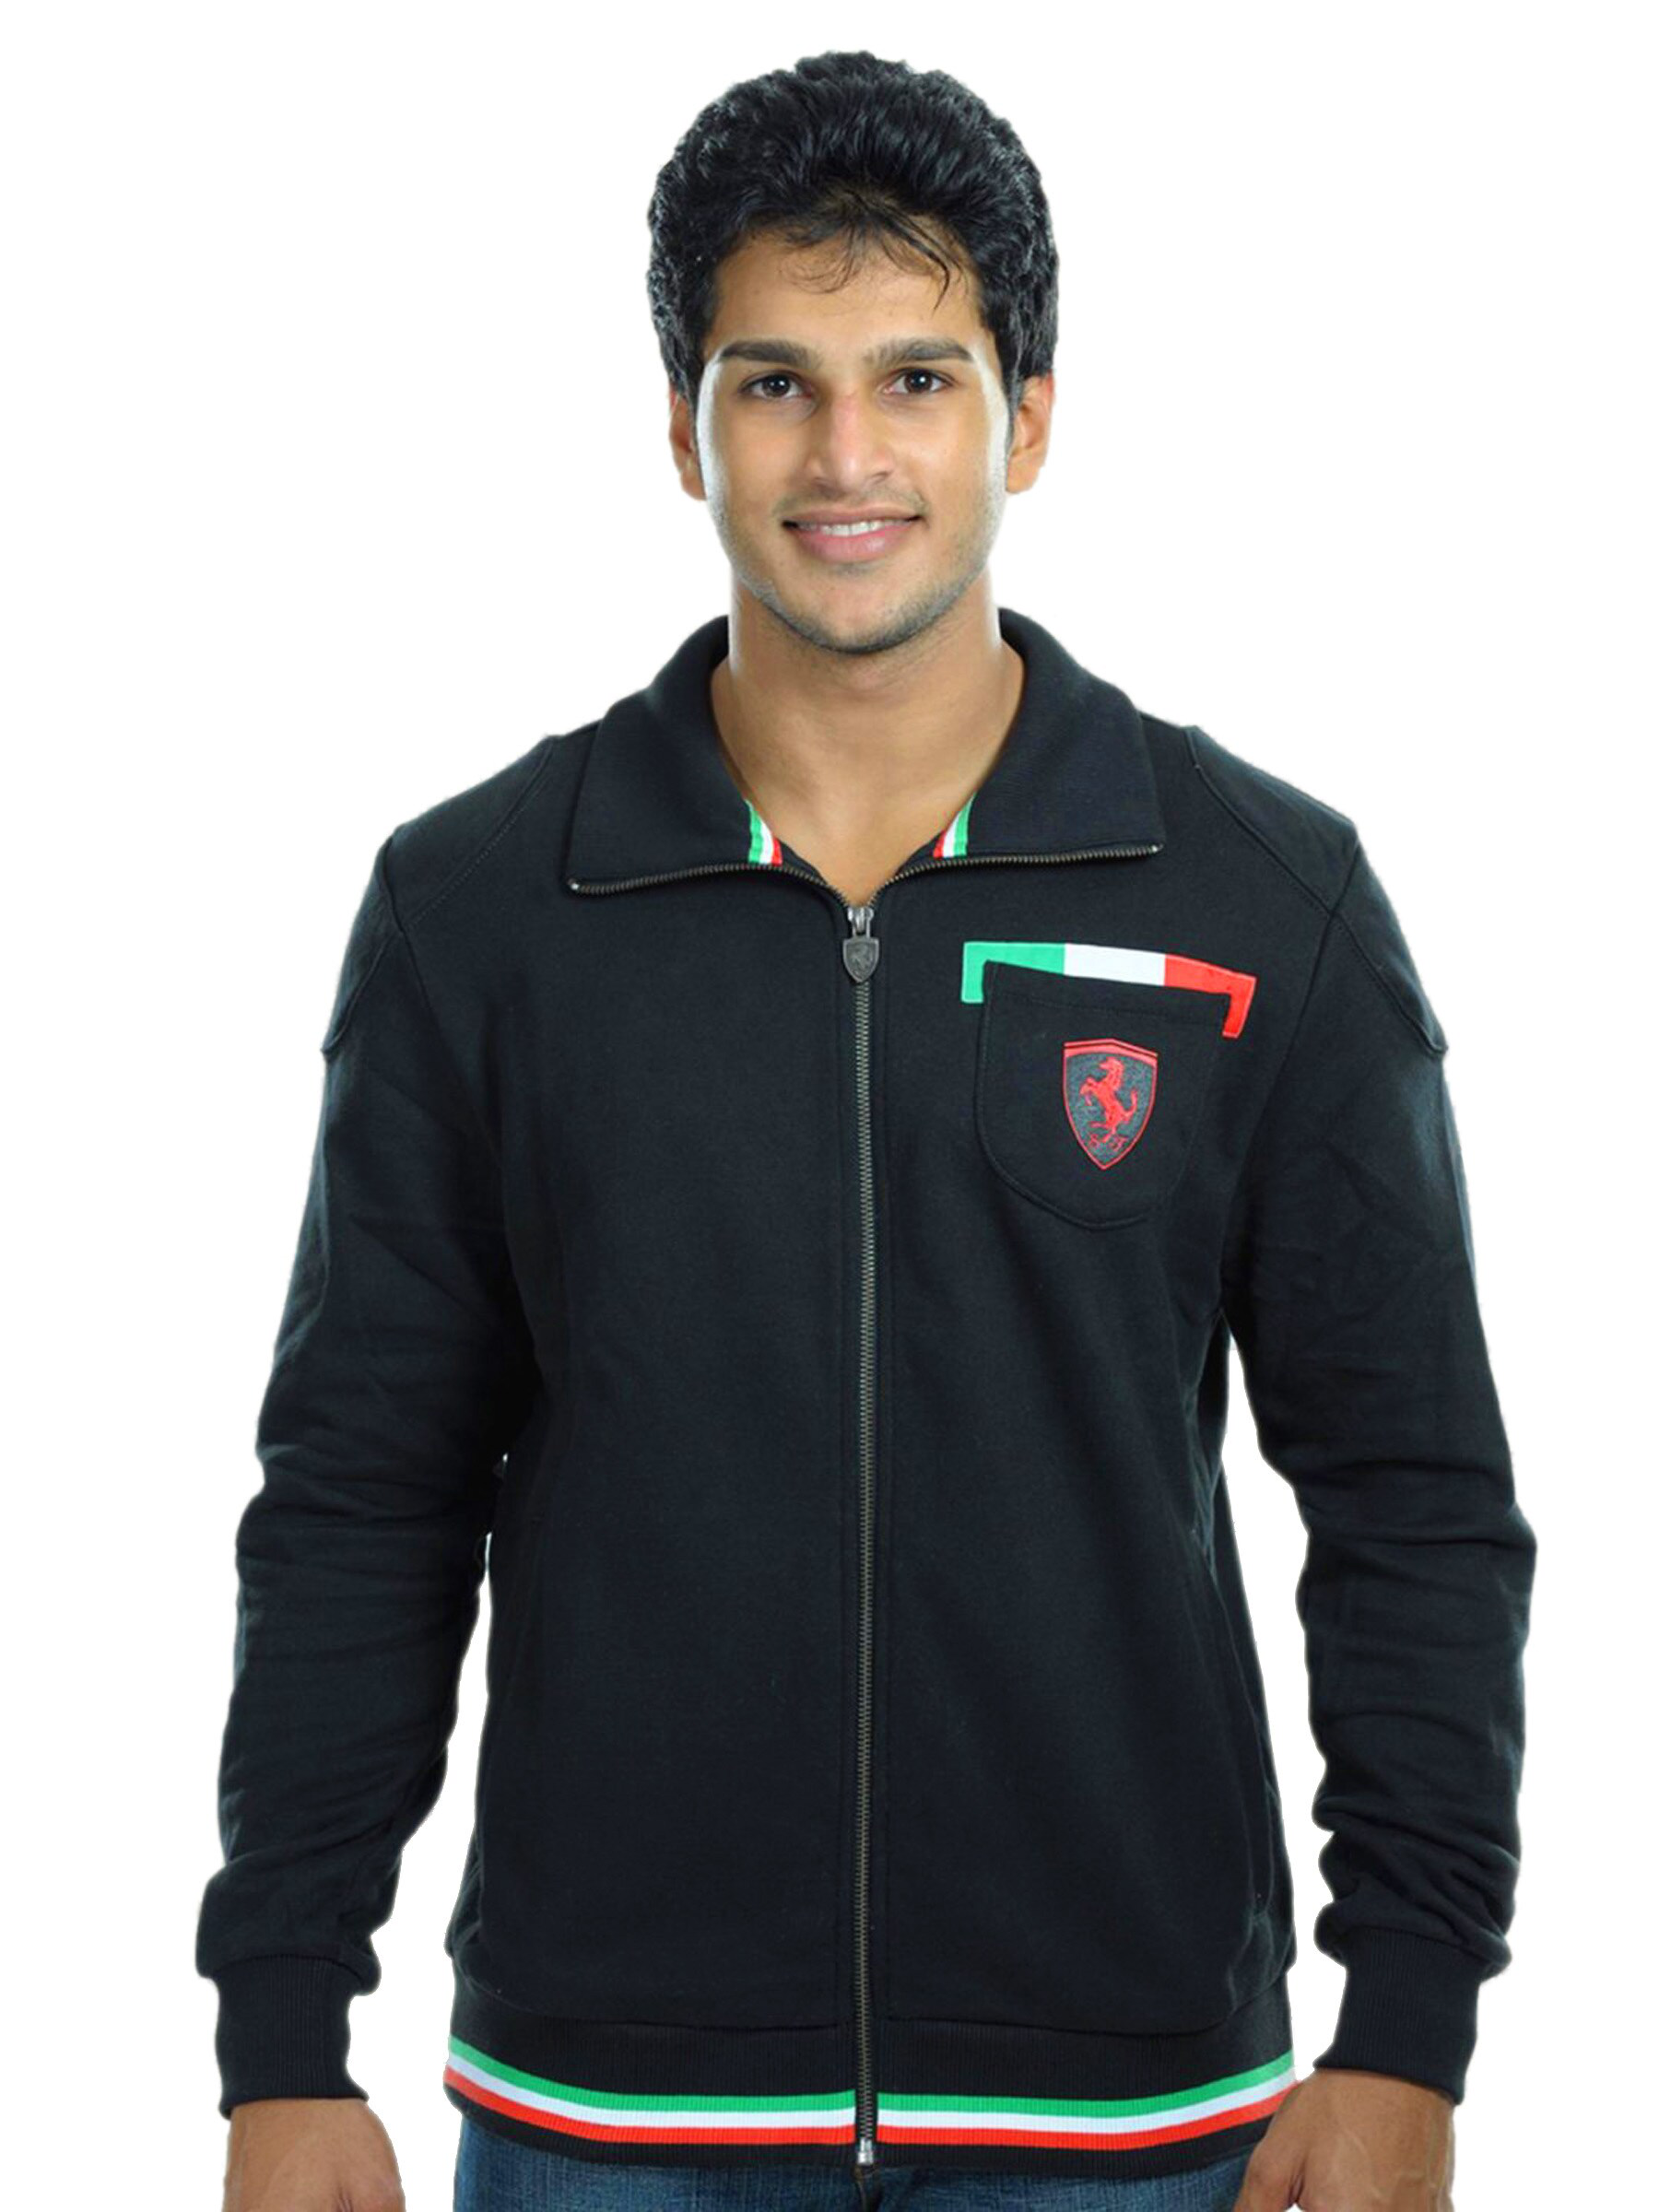

In [23]:
urllib.request.urlretrieve(
  df.iloc[5,1],
   "first_photo.jpg")
   
img = Image.open("first_photo.jpg")
img

In [21]:
urllib.request.urlretrieve(
  df.iloc[20,1],
   "second_photo.jpg")
   
img = Image.open("second_photo.jpg")
img

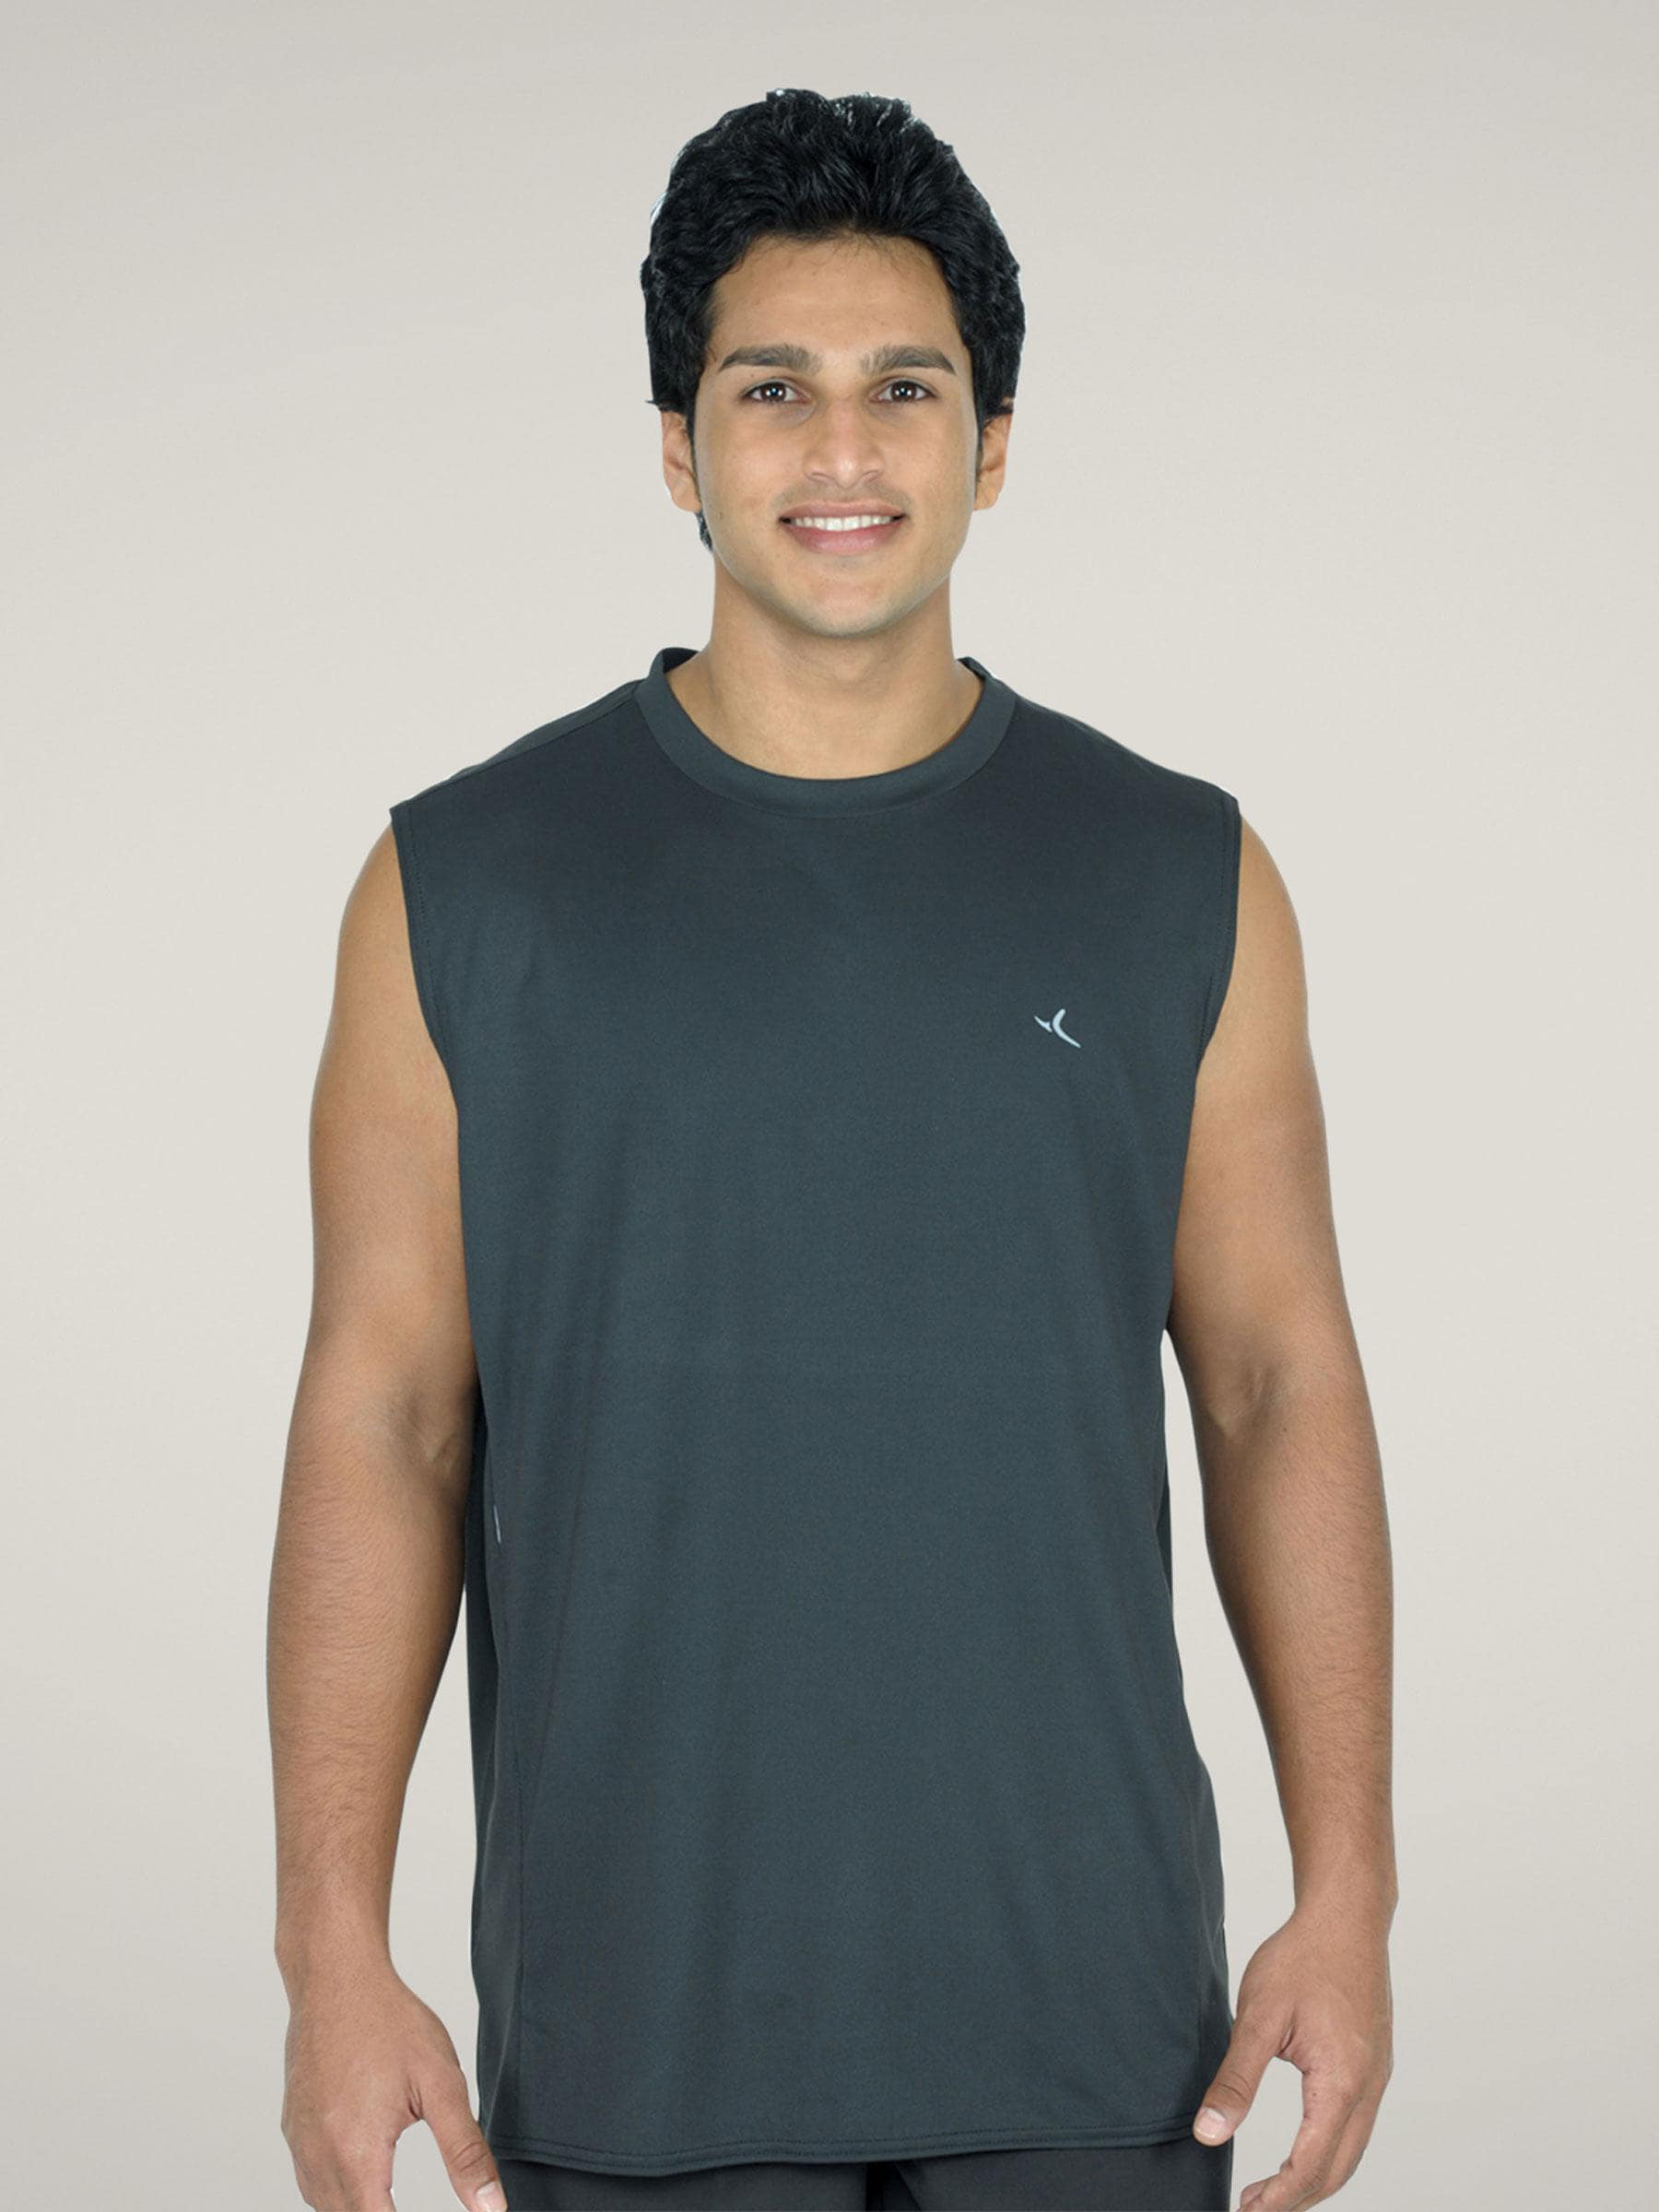

In [30]:
urllib.request.urlretrieve(
  df.iloc[50,1],
   "third_photo.jpg")
   
img = Image.open("third_photo.jpg")
img

Terlihat pada dataset ini berisikan image product fashion yang bervariasi.

# Data Preprocessing

Melakukan pemngambilan data untuk membuat model dimana data yang digunakan sebanyak 5000 gambar saja agar proses prediksi model tidak terlalu lama.

In [36]:
#filter 5000 data images saja
df_final = df[df['directory']<7488]
df_final

filename                                               link  directory
0     1163.jpg  http://assets.myntassets.com/v1/images/style/p...       1163
1     1164.jpg  http://assets.myntassets.com/v1/images/style/p...       1164
2     1165.jpg  http://assets.myntassets.com/assets/images/116...       1165
3     1525.jpg  http://assets.myntassets.com/v1/images/style/p...       1525
4     1526.jpg  http://assets.myntassets.com/v1/images/style/p...       1526
...        ...                                                ...        ...
4995  7482.jpg  http://assets.myntassets.com/v1/images/style/p...       7482
4996  7483.jpg  http://assets.myntassets.com/v1/images/style/p...       7483
4997  7484.jpg  http://assets.myntassets.com/v1/images/style/p...       7484
4998  7486.jpg  http://assets.myntassets.com/v1/images/style/p...       7486
4999  7487.jpg  http://assets.myntassets.com/v1/images/style/p...       7487

[5000 rows x 3 columns]

Membuat list Filenames yang dimana akan berisikan directory dari setiap image product :

In [37]:
filenames = [] # list file names

# Looping untuk update list filenames (directory path) setiap iamge 
for file in os.listdir('dataset/images/'):
    filenames.append(os.path.join('dataset/images/',file)) 

Mengambil data url link dari setiap produk dan dimasukkan pada list url_directory :

In [8]:
# Mengambil data url link dari setiap produk dan dimasukkan pada list url_directory
url_dir=df_final['link']
url_dir

0       http://assets.myntassets.com/v1/images/style/p...
1       http://assets.myntassets.com/v1/images/style/p...
2       http://assets.myntassets.com/assets/images/116...
3       http://assets.myntassets.com/v1/images/style/p...
4       http://assets.myntassets.com/v1/images/style/p...
                              ...                        
4995    http://assets.myntassets.com/v1/images/style/p...
4996    http://assets.myntassets.com/v1/images/style/p...
4997    http://assets.myntassets.com/v1/images/style/p...
4998    http://assets.myntassets.com/v1/images/style/p...
4999    http://assets.myntassets.com/v1/images/style/p...
Name: link, Length: 5000, dtype: object

# Model Definition

Dalam membuat Recommender System ini akan digunakan Pretrained Model yaitu ResNet 50 dimana ini adalah sebuah Convolutional Neural Network yang biasa digunakan untuk memproses data 2 dimensi seperti gamabar.

ResNet50 digunakan karena model yang terbaik untuk kasus pemrosesan gambar.

Input dari ResNet50 ini adalah sebuah gambar yang berdimensi 224x224.

In [2]:
model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

In [10]:
def extract_features(img_path,model):
    """Fungsi disini untuk melakukan extract features dimana:
    1. Image di load menjadi size 224,224 sesuai dengan sizeinput untuk ResNet50
    2. Image diubah menjadi array lalu di expand agar sesuai dengan input ResNet50
    3. Melakukan preprocess dengan menggunakan preprocess_input dari ResNet50
    4. result ini adalah melakukan extract features (predict) terhadap gambar lalu di flatten
    5. menghitung normalisasi dari hasil dimana pada feature extraction yang disimpan hasil normalisasinya
    """
    img = image.load_img(img_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img,verbose=0).flatten()
    normalized_result = result / norm(result)

    return normalized_result


# Feature Extraction from image

Melakukan features extraction pada gambar dimana disini akan didapat sebuah feature vector dari setiap gambar di database yang kita miliki yang dimana database ini akan digunakan sebagai storage product rekomendasi kepada customer.

Feature Vector ini adalah sebuah vector 1 dimensi yang dimana vector ini mewakilkan isi dari feature-feature dari setiap product.

In [11]:
feature_list = [] # List kosong ini akan diisi dengan hasil ekstraksi feature pada gambar

In [12]:
#Proses eksstraksinya
for file in tqdm(filenames):
    feature_list.append(extract_features(file,model)) #memasukan filepath image dan modelnya

100%|██████████| 5000/5000 [10:07<00:00,  8.23it/s]


# Model Recommender

Model untuk melakukan rekomendasi ini dilihat dari kemiripan dari produk dengan produk lainnya.

Sehingga disini digunakan modek K-NN (nearest Neighbors) dimana melihat kedekatan jarak antar feature vector dari suatu gambar nantinya.

Lima gambar yang memiliki kemiripan dengan product yang dikirimkan oleh customer akan direkomendasikan ke customer.

Output dari model ini adalah sebuah index dimana index ini akan digunakan sebagai referensi gambar pada database. Sehingga terdapat 5 gambar rekomendasi ke customer.

## Training Model Recommender

In [32]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [44]:
def recommend(features):
    distances, indices = neighbors.kneighbors([features])
    return indices

# Saving Model

In [ ]:
pickle.dump(feature_list,open('embeddings1.pkl','wb')) #simpan feature list
pickle.dump(filenames,open('filenames1.pkl','wb')) # simpan filepath
pickle.dump(url_dir,open('url_directory1.pkl','wb')) # simpan url directory
pickle.dump(model,open('recommender.pkl','wb')) #simpan model feature extraction
pickle.dump(neighbors,open('model_similarity.pkl','wb')) #simpan model similarity

# Model Inference

Disini kami akan menyoba jika customer mengirimkan sebuah gambar yang berisikan 1 set outfit :

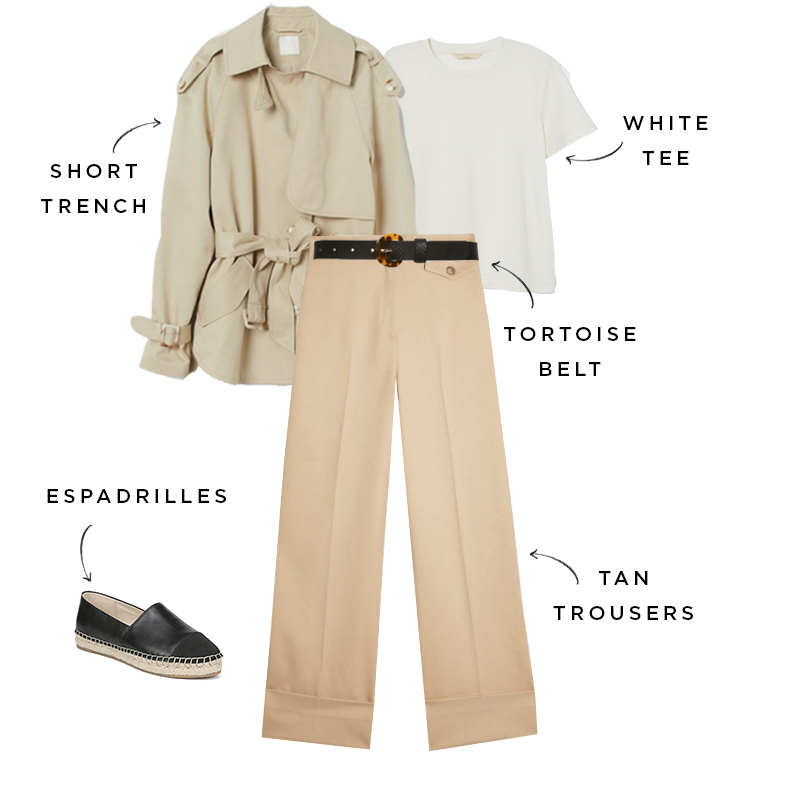

In [34]:
inference = Image.open('inference.jpg')
inference

## Feature Extraction

Melakukan Feature Extraction terhadap gambar inference :

In [43]:
fe_inference = extract_features('inference.jpg',model)

## Recommendation Model

Menghitung similariy foto yang dikirim customer terhadap product-product yang ada di database:

In [47]:
recom_inference = recommend(fe_inference)
recom_inference

array([[4461, 4468,  277, 4300, 2446, 4183]], dtype=int64)

Terlihat bahwa produk yang mirip dengan foto yang dikirim oleh customer berada pada database dengan index 4461, 4468,  277, 4300, 2446, 4183.

## Recommendation to Customer

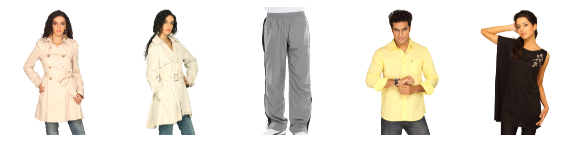

In [55]:
fig2,ax2=plt.subplots(ncols=5,figsize=(10,6))
for i in range(0,5):
  a=Image.open(filenames[recom_inference[0][i]])
  ax2[i].imshow(a)
  ax2[i].axis('off')

Ini adalah produk-produk yang direkomendasikan kepada customer yang dimiliki dari database catalog dari suatu e-commerce.

Terlihat bahwa terdapat kemiripan dari suatu product seperti dari jenis ataupun warna.

Sehingga model rekomendasi ini ketepatan pemberian rekomendasi bergantung terhadap sebarapa banyak varians ataupun jenis suatu catalog product fashion yang dimiliki suatu e-commerce.

# Conclusion

- Database catalog product fashion yang dimiliki cukup beragam. Terlihat tidak hanya ada pakain atas dan bawah, tetapi juga ada sepatu dan sebagainya.
- Berhasil memberikan rekomendasi fashion kepada customer.

# Further Improvement

- Mencoba menambahkan variasi dan jensi fashion pada database agar rekomendasi yang dapat diberikan kepada customer lebih tepat.
- Mencoba model Feature Extraction selain ResNet50 untuk melihat perbedaan dari hasil rekomendasinya.